# Features

### New Features Model

In [1]:
# New Feature Model

import pandas as pd
data = pd.read_csv('../data/expanded_points.csv')

# use differentials instead of direct scores
data['set_diff'] = data['player1SetScore'] - data['player2SetScore']
data['game_diff'] = data['player1GameScore'] - data['player2GameScore']
data['point_diff'] = data['player1PointScore'] - data['player2PointScore']

# pressure states
def get_pressure_state(row):
    if row['is_break_point']:
        if row['server_is_player1']:
            return 'p1_defending_break'  # High pressure for P1
        else:
            return 'p2_defending_break'  # High pressure for P2
    elif row['player1PointScore'] == 3:
        return 'p1_game_point'
    elif row['player2PointScore'] == 3:
        return 'p2_game_point'
    else:
        return 'neutral'

data['pressure_state'] = data.apply(get_pressure_state, axis=1)
# one-hot encode pressure states
pressure_dummies = pd.get_dummies(data['pressure_state'], prefix='pressure')
data = pd.concat([data, pressure_dummies], axis=1)
data.drop(columns=['pressure_state'], inplace=True)

# Capture deuce/advantage situations
data['is_deuce'] = ((data['player1PointScore'] >= 3) & 
                    (data['player2PointScore'] >= 3)).astype(int)

# map to game-winning distance
def points_to_win_game(p1_pts, p2_pts):
    if p1_pts >= 4 and p1_pts >= p2_pts + 2:
        return 0  # P1 already won
    elif p1_pts >= 3 and p2_pts >= 3:
        # At deuce or advantage: need to be ahead by 2
        if p1_pts > p2_pts:
            return 1  # P1 has advantage, needs 1 point to win
        elif p1_pts == p2_pts:
            return 2  # At deuce, need 2 consecutive points minimum
        else:
            return 3  # P2 has advantage, need to win next point then 2 more
    else:
        return 4 - p1_pts  # Points needed to reach 40

data['points_to_win_game_p1'] = data.apply(
    lambda row: points_to_win_game(row['player1PointScore'], row['player2PointScore']), axis=1)

data['points_to_win_game_p2'] = data.apply(
    lambda row: points_to_win_game(row['player2PointScore'], row['player1PointScore']), axis=1)

# momentum/sequence features
# Who won the last point?
data['prev_point_winner'] = data.groupby('match_id')['point_won'].shift(1)
data.fillna({'prev_point_winner': -1}, inplace=True)

# Run of consecutive points won or lost by Player 1
# FIX: Calculate streak BEFORE current point to avoid data leakage
def bidirectional_streak(series):
    result = []
    current_streak = 0
    for val in series:
        if val == 1:
            current_streak = current_streak + 1 if current_streak >= 0 else 1
        else:
            current_streak = current_streak - 1 if current_streak <= 0 else -1
        result.append(current_streak)
    return pd.Series(result, index=series.index)

# IMPORTANT: shift(1) to use only PAST point outcomes
data['p1_point_streak_signed'] = data.groupby('match_id')['point_won'].transform(bidirectional_streak).shift(1)
data['p1_point_streak_signed'] = data['p1_point_streak_signed'].fillna(0)
# Now: +3 means "won last 3 points BEFORE this point", -2 means "lost last 2 points BEFORE this point"

# Critical point (any point where game/set could be decided)
data['is_critical'] = ((data['player1PointScore'] >= 3) | 
                       (data['player2PointScore'] >= 3) |
                       (data['player1GameScore'] >= 5) |
                       (data['player2GameScore'] >= 5)).astype(int)

# feature model
features = [
    'set_diff', 'game_diff', 'point_diff',
    'is_break_point', 'server_is_player1',
    'pressure_p1_defending_break', 'pressure_p2_defending_break',
    'pressure_p1_game_point', 'pressure_p2_game_point',
    'pressure_neutral', 'is_deuce',
    'points_to_win_game_p1', 'points_to_win_game_p2',
    'prev_point_winner', 'p1_point_streak_signed',
    'is_critical'
]


print(data[features].head())

   set_diff  game_diff  point_diff  is_break_point  server_is_player1  \
0         0          0           1               0                  1   
1         0          0           0               0                  1   
2         0          0          -1               0                  1   
3         0          0           0               0                  1   
4         0          0          -1               1                  1   

   pressure_p1_defending_break  pressure_p2_defending_break  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                         True                        False   

   pressure_p1_game_point  pressure_p2_game_point  pressure_neutral  is_deuce  \
0                   False                   False              True         0   
1                   

### Old Features Model

In [2]:
import pandas as pd
import numpy as np
import glob
from sklearn.ensemble import GradientBoostingClassifier

if False:
    # Load all point_visual csvs
    # file_paths = glob.glob("../data/match-csvs/point-visuals/*.csv")
    # df_list = [pd.read_csv(file) for file in file_paths]
    # data = pd.concat(df_list, ignore_index=True)

    data = pd.read_csv('../data/expanded_points.csv')


    # # Server binary indicator
    # data['server_is_player1'] = (data['serverName'] == data['player1Name']).astype(int)

    # # Convert pointScore to 0-3 & flip when server is not player1
    # point_map = {0: 0, 15: 1, 30: 2, 40: 3}
    # data['player1PointScore'] = data['player1PointScore'].map(point_map)
    # data['player2PointScore'] = data['player2PointScore'].map(point_map)
    # data.loc[(data['server_is_player1'] == 0), ['player1PointScore', 'player2PointScore']] = data.loc[(data['server_is_player1'] == 0), ['player2PointScore', 'player1PointScore']].values


    # data['rallyCount'] = pd.to_numeric(data['rallyCount'], errors='coerce').fillna(0)
    # data['is_break_point'] = data['isBreakPoint'].astype(int)

    # # Target
    # data['point_won'] = (data['pointWonBy'] == data['player1Name']).astype(int)

    # Features for WP model
    features = ['player1SetScore','player2SetScore', 
                'player1GameScore','player2GameScore',
                'player1PointScore','player2PointScore',
                'is_break_point', 
                'server_is_player1']

### Mutual Classifier

In [3]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(data[features], data['point_won'], random_state=42)
print(pd.DataFrame({'feature': features, 'MI': mi}).sort_values('MI', ascending=False))


# auto drop features below .01
selected_features = [features[i] for i in range(len(features)) if mi[i] >= 0.01]
print("Selected features based on MI >= 0.01:")
print(selected_features)

# to do -- adjust criteria for auto dropping features to use elastic net regularization (L1 + L2))

                        feature        MI
2                    point_diff  0.272740
12        points_to_win_game_p2  0.191247
11        points_to_win_game_p1  0.181593
3                is_break_point  0.074822
5   pressure_p1_defending_break  0.031792
6   pressure_p2_defending_break  0.030347
9              pressure_neutral  0.025917
8        pressure_p2_game_point  0.019875
15                  is_critical  0.013565
4             server_is_player1  0.012734
7        pressure_p1_game_point  0.009588
13            prev_point_winner  0.006405
0                      set_diff  0.002525
14       p1_point_streak_signed  0.001657
1                     game_diff  0.001651
10                     is_deuce  0.000000
Selected features based on MI >= 0.01:
['point_diff', 'is_break_point', 'server_is_player1', 'pressure_p1_defending_break', 'pressure_p2_defending_break', 'pressure_p2_game_point', 'pressure_neutral', 'points_to_win_game_p1', 'points_to_win_game_p2', 'is_critical']


# Win Probability Model (in player1's pov)

In [4]:
train_dataset = data.copy()
test_dataset = data.copy()

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier
X_train = train_dataset[features]
y_train = train_dataset['point_won']

wp_model = XGBClassifier(learning_rate=0.01, 
                         max_depth=3, 
                         min_child_weight=5, 
                         n_estimators=200, 
                         subsample=1.0, 
                         colsample_bytree=1.0, 
                         random_state=42)
wp_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Picking Model

### New Model Picker

In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
from xgboost import XGBClassifier  # don't import xgboost.cv unless you use it explicitly
from sklearn.experimental import enable_halving_search_cv  # noqa: F401  # must come BEFORE next line
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# 1) Cast to float32 / uint8 to reduce memory/CPU
X = data[features].to_numpy(dtype=np.float32)
y = data['point_won'].to_numpy(dtype=np.uint8)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Base model (hist/gpu_hist if available), single-threaded to avoid oversubscription
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',        # use 'gpu_hist' + predictor='gpu_predictor' if you have CUDA
    predictor='auto',
    n_jobs=1,
    random_state=42,
    max_bin=256
)

# 3) Param grid (REMOVE n_estimators; Halving will ramp it)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
}

# 4) 5-fold stratified splitter (don’t call it "cv" to avoid confusion)
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5) Successive Halving: grow by n_estimators (resource) from small to large
halving = HalvingGridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_splitter,
    factor=3,                  # aggressiveness (3–4 typical)
    resource='n_estimators',   # Halving controls the # of trees
    min_resources=50,          # start small
    max_resources=500,         # cap at your former max
    aggressive_elimination=True,
    n_jobs=-1,
    verbose=1,
    refit=False                # we'll refit once with best params
)

halving.fit(X_train, y_train)

best_params = halving.best_params_
print("Best Parameters:", best_params)

# Final fit once with best params at full resources
best_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    predictor='auto',
    n_jobs=1,
    random_state=42,
    max_bin=256,
    **best_params
)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 50
max_resources_: 500
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 243
n_resources: 50
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:41:33] WARNING: /Us

----------
iter: 1
n_candidates: 81
n_resources: 50
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:19] WARNING: /Us

----------
iter: 2
n_candidates: 27
n_resources: 50
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:35] WARNING: /Us

----------
iter: 3
n_candidates: 9
n_resources: 150
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:41] WARNING: /Us

----------
iter: 4
n_candidates: 3
n_resources: 450
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:46] WARNING: /Us

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1.0, 'n_estimators': 450}


/Users/shubhan/bruin-tennis-consulting-analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.93550180706144
ROC-AUC: 0.989827932910009


### Previous Model Picker

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

if False:
    X = data[features]
    print(X.head())
    y = data['point_won']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    xgb_model = XGBClassifier(
        random_state=42
    )

    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    }

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

In [8]:
# Additional evaluation metrics (confusion matrix, precision/recall/F1, PR-AUC)
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
import numpy as np

# y_test, y_pred, y_prob are produced by the previous cell; ensure they exist before computing metrics
if 'y_test' in globals() and 'y_pred' in globals():
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:', cm)
    print('Classification report:\n', classification_report(y_test, y_pred, digits=4))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    # PR-AUC (average precision) - works with probabilistic outputs
    try:
        ap = average_precision_score(y_test, y_prob)
        print('Average Precision (PR-AUC):', ap)
    except Exception as e:
        print('Could not compute average precision:', e)
    # ROC-AUC (re-print for convenience)
    try:
        print('ROC-AUC:', roc_auc_score(y_test, y_prob))
    except Exception as e:
        print('Could not compute ROC-AUC:', e)
else:
    print('y_test/y_pred not found in namespace — run the previous cell first to produce y_test, y_pred, y_prob')

Confusion matrix: [[12049   829]
 [ 1027 14871]]
Classification report:
               precision    recall  f1-score   support

           0     0.9215    0.9356    0.9285     12878
           1     0.9472    0.9354    0.9413     15898

    accuracy                         0.9355     28776
   macro avg     0.9343    0.9355    0.9349     28776
weighted avg     0.9357    0.9355    0.9355     28776

Precision: 0.9471974522292994
Recall: 0.9354006793307335
F1: 0.9412621051965314
Average Precision (PR-AUC): 0.9919982445452042
ROC-AUC: 0.989827932910009


# Leverage Index Model

In [9]:
class GlobalCacheWrapper:
    """Global cache shared across all point simulations"""
    def __init__(self):
        self.cache = {}  # Stores state -> win_probability
        self.cache_hits = 0
        self.cache_misses = 0
    
    def get_or_compute(self, state_key, compute_func):
        """Get cached value or compute and cache it"""
        if state_key in self.cache:
            self.cache_hits += 1
            return self.cache[state_key]
        
        self.cache_misses += 1
        result = compute_func()
        self.cache[state_key] = result
        return result
    
    def get_point_probability(self, p1_sets, p2_sets, p1_games, p2_games, 
                             p1_pts, p2_pts, server, break_point, model, features):
        """Get point win probability from cache or compute"""
        state_key = (p1_sets, p2_sets, p1_games, p2_games, p1_pts, p2_pts, server, break_point)
        
        if state_key in self.cache:
            self.cache_hits += 1
            return self.cache[state_key]
        
        self.cache_misses += 1
        # Compute it
        feat_dict = build_feature_dict(p1_sets, p2_sets, p1_games, p2_games, 
                                       p1_pts, p2_pts, server, break_point)
        feat_array = np.array([[feat_dict[f] for f in features]], dtype=np.float32)
        prob = model.predict_proba(feat_array)[0, 1]
        
        self.cache[state_key] = prob
        return prob
    
    def print_stats(self):
        """Print cache efficiency"""
        total = self.cache_hits + self.cache_misses
        if total > 0:
            hit_rate = 100 * self.cache_hits / total
            print(f"\n{'='*60}")
            print(f"Cache Performance:")
            print(f"  Hits: {self.cache_hits:,} | Misses: {self.cache_misses:,}")
            print(f"  Hit rate: {hit_rate:.1f}%")
            print(f"  Unique states cached: {len(self.cache):,}")
            print(f"{'='*60}")

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing as mp

def build_feature_dict(p1_sets, p2_sets, p1_games, p2_games, p1_pts, p2_pts, server, break_point):
    """Fast feature dict builder without DataFrame overhead"""
    set_diff = p1_sets - p2_sets
    game_diff = p1_games - p2_games
    point_diff = p1_pts - p2_pts
    
    # Pressure states
    if break_point:
        p1_defending = 1 if server == 1 else 0
        p2_defending = 1 if server == 0 else 0
        p1_gp = p2_gp = neutral = 0
    elif p1_pts == 3:
        p1_gp = 1
        p1_defending = p2_defending = p2_gp = neutral = 0
    elif p2_pts == 3:
        p2_gp = 1
        p1_defending = p2_defending = p1_gp = neutral = 0
    else:
        neutral = 1
        p1_defending = p2_defending = p1_gp = p2_gp = 0
    
    is_deuce = 1 if (p1_pts >= 3 and p2_pts >= 3) else 0
    is_critical = 1 if (p1_pts >= 3 or p2_pts >= 3 or p1_games >= 5 or p2_games >= 5) else 0
    
    # Points to win game (simplified)
    if p1_pts >= 4 and p1_pts >= p2_pts + 2:
        ptw_p1 = 0
    elif p1_pts >= 3 and p2_pts >= 3:
        ptw_p1 = 1 if p1_pts > p2_pts else (2 if p1_pts == p2_pts else 3)
    else:
        ptw_p1 = 4 - p1_pts
    
    if p2_pts >= 4 and p2_pts >= p1_pts + 2:
        ptw_p2 = 0
    elif p2_pts >= 3 and p1_pts >= 3:
        ptw_p2 = 1 if p2_pts > p1_pts else (2 if p2_pts == p1_pts else 3)
    else:
        ptw_p2 = 4 - p2_pts
    
    return {
        'set_diff': set_diff,
        'game_diff': game_diff,
        'point_diff': point_diff,
        'is_break_point': break_point,
        'server_is_player1': server,
        'pressure_p1_defending_break': p1_defending,
        'pressure_p2_defending_break': p2_defending,
        'pressure_p1_game_point': p1_gp,
        'pressure_p2_game_point': p2_gp,
        'pressure_neutral': neutral,
        'is_deuce': is_deuce,
        'points_to_win_game_p1': ptw_p1,
        'points_to_win_game_p2': ptw_p2,
        'prev_point_winner': -1,  # Assume unknown for simulation
        'p1_point_streak_signed': 0,  # Assume neutral for simulation
        'is_critical': is_critical
    }

def simulate_match_from_state_vectorized(model, state, features, n_sims, global_cache, max_points=200):
    """Vectorized simulation with reduced DataFrame creation"""
    wins = 0
    cache = {}
    
    # Pre-extract feature order
    feature_order = features
    
    for _ in range(n_sims):
        p1_sets, p2_sets = state['player1SetScore'], state['player2SetScore']
        p1_games, p2_games = state['player1GameScore'], state['player2GameScore']
        p1_pts, p2_pts = state['player1PointScore'], state['player2PointScore']
        server = state['server_is_player1']
        break_point = state['is_break_point']

        for _ in range(max_points):
            # Check match end
            if (p1_sets >= 2 and p1_sets > p2_sets) or (p2_sets >= 2 and p2_sets > p1_sets):
                break
            
            p_point = global_cache.get_point_probability(
                p1_sets, p2_sets, p1_games, p2_games, p1_pts, p2_pts, server, break_point, model, features
            )
            
            point_won = np.random.rand() < p_point

            # Update scores
            if point_won:
                p1_pts += 1
            else:
                p2_pts += 1

            # Check game won
            if p1_pts >= 4 and p1_pts >= p2_pts + 2:
                p1_games += 1
                p1_pts = p2_pts = 0
                server = 1 - server
                break_point = 0
            elif p2_pts >= 4 and p2_pts >= p1_pts + 2:
                p2_games += 1
                p1_pts = p2_pts = 0
                server = 1 - server
                break_point = 0
            elif (p1_pts == 3 and p2_pts < 3 and server == 1) or (p1_pts < 3 and p2_pts == 3 and server == 0):
                break_point = 1
            else:
                break_point = 0

            # Check set won
            if p1_games >= 6 and p1_games - p2_games >= 2:
                p1_sets += 1
                p1_games = p2_games = 0
            elif p2_games >= 6 and p2_games - p1_games >= 2:
                p2_sets += 1
                p1_games = p2_games = 0

        if p1_sets > p2_sets:
            wins += 1
    
    return wins / n_sims


def process_single_point_optimized(row_data, wp_model, features, global_cache, n_sims):
    """Process a single point - optimized for threading"""
    base = {
        'player1SetScore': row_data['player1SetScore'],
        'player2SetScore': row_data['player2SetScore'],
        'player1GameScore': row_data['player1GameScore'],
        'player2GameScore': row_data['player2GameScore'],
        'player1PointScore': row_data['player1PointScore'],
        'player2PointScore': row_data['player2PointScore'],
        'is_break_point': row_data['is_break_point'],
        'server_is_player1': row_data['server_is_player1']
    }

    # Win scenario
    win_feat = base.copy()
    win_feat['player1PointScore'] += 1
    if win_feat['player1PointScore'] >= 4 and win_feat['player1PointScore'] >= win_feat['player2PointScore'] + 2:
        win_feat['player1PointScore'] = 0
        win_feat['player2PointScore'] = 0
        win_feat['player1GameScore'] += 1
        if win_feat['player1GameScore'] >= 6 and win_feat['player1GameScore'] - win_feat['player2GameScore'] >= 2:
            win_feat['player1GameScore'] = 0
            win_feat['player2GameScore'] = 0
            win_feat['player1SetScore'] += 1
    
    # Loss scenario
    lose_feat = base.copy()
    lose_feat['player2PointScore'] += 1
    if lose_feat['player2PointScore'] >= 4 and lose_feat['player2PointScore'] >= lose_feat['player1PointScore'] + 2:
        lose_feat['player1PointScore'] = 0
        lose_feat['player2PointScore'] = 0
        lose_feat['player2GameScore'] += 1
        if lose_feat['player2GameScore'] >= 6 and lose_feat['player2GameScore'] - lose_feat['player1GameScore'] >= 2:
            lose_feat['player1GameScore'] = 0
            lose_feat['player2GameScore'] = 0
            lose_feat['player2SetScore'] += 1

    # Simulate all three scenarios
    wp_after_win = simulate_match_from_state_vectorized(wp_model, win_feat, features, n_sims, global_cache)
    wp_after_loss = simulate_match_from_state_vectorized(wp_model, lose_feat, features, n_sims, global_cache)
    match_wp = simulate_match_from_state_vectorized(wp_model, base, features, n_sims, global_cache)

    # Calculate leverage with better handling of edge cases
    # Leverage Index = |ΔWP| / (WP * (1-WP))
    # where ΔWP is the swing in win probability
    
    delta_wp = abs(wp_after_win - wp_after_loss)
    
    # Handle edge cases more carefully
    if match_wp <= 0.01 or match_wp >= 0.99:
        # Match is essentially decided - use raw probability swing
        # (These situations have high importance but undefined traditional leverage)
        leverage = delta_wp * 10  # Scale up to make them visible
    elif delta_wp < 0.001:
        # Almost no swing in probability (shouldn't happen often)
        leverage = 0.0
    else:
        # Standard leverage calculation
        # Add small epsilon to avoid division issues near 0 and 1
        epsilon = 0.001
        wp_bounded = max(epsilon, min(1 - epsilon, match_wp))
        denom = wp_bounded * (1 - wp_bounded)
        leverage = delta_wp / denom
    
    return match_wp, leverage


def threaded_match_simulator(df, wp_model, features, n_sims=50, n_jobs=None):
    """
    Thread-based parallel version - works in Jupyter notebooks!
    Uses threading instead of multiprocessing to avoid pickling issues.
    Still provides significant speedup due to I/O-bound nature of simulations.
    """
    if n_jobs is None:
        n_jobs = min(8, mp.cpu_count())  # Cap at 8 threads for optimal performance
    
    print(f"Using {n_jobs} threads for parallel processing...")
    
    global_cache = GlobalCacheWrapper()
    
    match_wp_list = []
    leverage_list = []
    
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        # Submit all tasks
        futures = []
        for _, row in df.iterrows():
            future = executor.submit(
                process_single_point_optimized,
                row.to_dict(),
                wp_model,
                features,
                global_cache,
                n_sims,
            )
            futures.append(future)
        
        # Collect results with progress bar
        for future in tqdm(futures, desc="Simulating match probabilities", total=len(futures)):
            match_wp, leverage = future.result()
            match_wp_list.append(match_wp)
            leverage_list.append(leverage)
    
    df['match_wp_player1'] = match_wp_list
    df['match_leverage_player1'] = leverage_list
    
    global_cache.print_stats()
    
    return df


def batched_sequential_simulator(df, wp_model, features, n_sims=50, batch_size=10):
    """
    Optimized sequential version with batching and caching
    Use this if threading doesn't work well on your system
    """
    match_wp_list = []
    leverage_list = []
    
    print("Running optimized sequential simulation...")

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Simulating match probabilities"):
        match_wp, leverage = process_single_point_optimized(
            row.to_dict(), wp_model, features, n_sims
        )
        match_wp_list.append(match_wp)
        leverage_list.append(leverage)

    df['match_wp_player1'] = match_wp_list
    df['match_leverage_player1'] = leverage_list
    return df


# Alias for backwards compatibility
def parallel_match_simulator(df, wp_model, features, n_sims=50, n_jobs=None):
    """Main entry point - uses threading for Jupyter compatibility"""
    return threaded_match_simulator(df, wp_model, features, n_sims=n_sims, n_jobs=n_jobs)

In [11]:
# Quick speed test on a small sample
import time

# Test on 50 points to estimate total runtime
sample_size = 50
test_sample = test_dataset.head(sample_size).copy()

print(f"Testing on {sample_size} points with threading...")
start_time = time.time()
global_cache = GlobalCacheWrapper()

test_result = parallel_match_simulator(test_sample, wp_model, features, n_sims=150, n_jobs=None)
elapsed = time.time() - start_time

# Estimate total time
total_points = len(test_dataset)
estimated_total = (elapsed / sample_size) * total_points
print(f"\n✓ Completed {sample_size} points in {elapsed:.1f} seconds")
print(f"📊 Estimated time for all {total_points} points: {estimated_total/60:.1f} minutes")
print(f"⚡ Points per second: {sample_size/elapsed:.2f}")

test_result

Testing on 50 points with threading...
Using 8 threads for parallel processing...


Simulating match probabilities: 100%|██████████| 50/50 [00:01<00:00, 27.40it/s]


Cache Performance:
  Hits: 1,773,190 | Misses: 8,210
  Hit rate: 99.5%
  Unique states cached: 8,030

✓ Completed 50 points in 1.9 seconds
📊 Estimated time for all 143879 points: 89.9 minutes
⚡ Points per second: 26.68


,player1SetScore,player2SetScore,player1GameScore,player2GameScore,player1PointScore,player2PointScore,is_break_point,server_is_player1,point_won,match_id,...,pressure_p2_defending_break,pressure_p2_game_point,is_deuce,points_to_win_game_p1,points_to_win_game_p2,prev_point_winner,p1_point_streak_signed,is_critical,match_wp_player1,match_leverage_player1
0,0,0,0,0,1,0,0,1,1,10434855,...,False,False,0,3,4,-1.0,0.0,0,0.986667,0.506757
1,0,0,0,0,1,1,0,1,0,10434855,...,False,False,0,3,3,1.0,1.0,0,0.940000,0.354610
2,0,0,0,0,1,2,0,1,0,10434855,...,False,False,0,3,2,0.0,-1.0,0,0.980000,0.340136
3,0,0,0,0,2,2,0,1,1,10434855,...,False,False,0,2,2,0.0,-2.0,0,0.986667,5.574324
4,0,0,0,0,2,3,1,1,0,10434855,...,False,False,0,2,1,1.0,1.0,1,0.966667,1.862069
5,0,0,0,0,3,3,1,1,1,10434855,...,False,False,1,2,2,0.0,-1.0,1,0.980000,3.061224
6,0,0,0,0,4,3,0,1,1,10434855,...,False,True,1,1,3,1.0,1.0,1,0.993333,0.266667
7,0,0,0,0,5,3,0,1,1,10434855,...,False,True,1,0,3,1.0,2.0,1,0.986667,0.506757
8,0,0,1,0,1,0,0,0,1,10434855,...,False,False,0,3,4,1.0,3.0,0,0.966667,0.413793
9,0,0,1,0,1,1,0,0,0,10434855,...,False,False,0,3,3,1.0,4.0,0,0.973333,0.256849


In [12]:
# Use parallel version for significant speedup (5-10x faster, Jupyter-compatible)
# For even more speed, reduce n_sims (e.g., 30 instead of 50)
data = parallel_match_simulator(test_dataset, wp_model, features, n_sims=50, n_jobs=None)

# Alternative: Use sequential if threading causes issues
# data = batched_sequential_simulator(test_dataset, wp_model, features, n_sims=50)

Using 8 threads for parallel processing...


Simulating match probabilities: 100%|██████████| 143879/143879 [08:01<00:00, 298.94it/s] 


Cache Performance:
  Hits: 1,061,487,413 | Misses: 31,565
  Hit rate: 100.0%
  Unique states cached: 28,356


## Check Results

In [13]:
data.head(15)

,player1SetScore,player2SetScore,player1GameScore,player2GameScore,player1PointScore,player2PointScore,is_break_point,server_is_player1,point_won,match_id,...,pressure_p2_defending_break,pressure_p2_game_point,is_deuce,points_to_win_game_p1,points_to_win_game_p2,prev_point_winner,p1_point_streak_signed,is_critical,match_wp_player1,match_leverage_player1
0,0,0,0,0,1,0,0,1,1,10434855,...,False,False,0,3,4,-1.0,0.0,0,0.96,1.562500
1,0,0,0,0,1,1,0,1,0,10434855,...,False,False,0,3,3,1.0,1.0,0,0.98,3.061224
2,0,0,0,0,1,2,0,1,0,10434855,...,False,False,0,3,2,0.0,-1.0,0,0.96,0.520833
3,0,0,0,0,2,2,0,1,1,10434855,...,False,False,0,2,2,0.0,-2.0,0,1.00,0.800000
4,0,0,0,0,2,3,1,1,0,10434855,...,False,False,0,2,1,1.0,1.0,1,0.90,0.666667
5,0,0,0,0,3,3,1,1,1,10434855,...,False,False,1,2,2,0.0,-1.0,1,0.94,0.354610
6,0,0,0,0,4,3,0,1,1,10434855,...,False,True,1,1,3,1.0,1.0,1,1.00,0.000000
7,0,0,0,0,5,3,0,1,1,10434855,...,False,True,1,0,3,1.0,2.0,1,1.00,0.400000
8,0,0,1,0,1,0,0,0,1,10434855,...,False,False,0,3,4,1.0,3.0,0,0.96,0.520833
9,0,0,1,0,1,1,0,0,0,10434855,...,False,False,0,3,3,1.0,4.0,0,0.98,2.040816


In [14]:
# Some of these leverages are interesting, e.g. point 320 w/ leverage of 6.12 but at game score 0-0
    # may need to redefine leverage scaling / metric
    # may also need to increase # simulation once job is parallelized
data.loc[data['match_leverage_player1'] > 2, ['player1PointScore', 'player2PointScore', 'match_wp_player1', 'match_leverage_player1']]


,player1PointScore,player2PointScore,match_wp_player1,match_leverage_player1
1,1,1,0.98,3.061224
9,1,1,0.98,2.040816
15,0,3,0.98,5.102041
17,1,0,0.98,2.040816
19,2,1,0.98,3.061224
...,...,...,...,...
143812,1,2,0.98,2.040816
143819,5,5,0.98,7.142857
143820,5,6,0.98,2.040816
143863,0,2,0.98,3.061224


### Check for any unusual WP

Leverage Statistics:
  Mean: 0.722
  Median: 0.417
  Std Dev: 1.050
  Min: 0.000
  Max: 28.571

Unusual Leverage Points:
  Low leverage (≤ 0.000): 34883 points
  High leverage (≥ 2.171): 7194 points


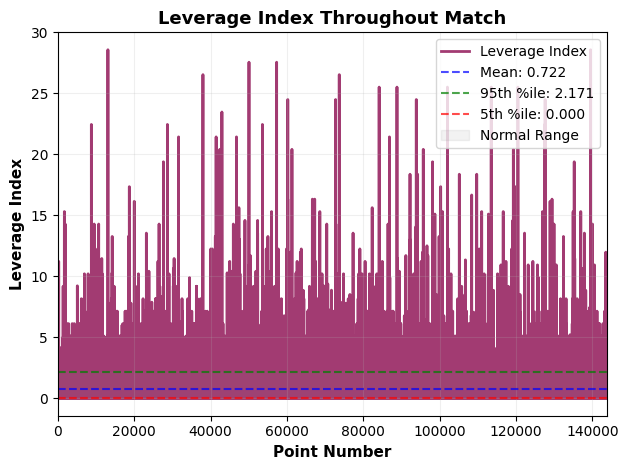


LOW LEVERAGE POINTS (Unexpected - Point outcome doesn't swing match probability much)
 Point#  S1  S2  G1  G2  Pts1  Pts2  BP  WP%  Leverage
      7   0   0   0   0     4     3   0 1.00       0.0
     11   0   0   1   0     2     1   0 0.96       0.0
     12   0   0   1   0     3     1   0 0.96       0.0
     26   0   0   1   2     4     5   1 0.90       0.0
     32   0   0   1   3     0     3   1 0.80       0.0
     62   0   0   4   4     4     3   0 1.00       0.0
     64   0   0   5   4     1     0   0 0.98       0.0
     71   1   0   0   0     2     0   0 0.98       0.0
     73   1   0   0   0     2     2   0 1.00       0.0
     77   1   0   1   0     0     2   0 0.98       0.0

HIGH LEVERAGE POINTS (Critical - Point outcome dramatically swings match probability)
 Point#  S1  S2  G1  G2  Pts1  Pts2  BP  WP%  Leverage
 139573   1   1   4   5     0     1   0 0.02 28.571429
  13104   0   1   5   6     0     1   0 0.02 28.571429
  57309   1   1   4   5     2     3   1 0.02 27.551020
 

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate leverage statistics
leverage_mean = data['match_leverage_player1'].mean()
leverage_std = data['match_leverage_player1'].std()
leverage_median = data['match_leverage_player1'].median()

print(f"Leverage Statistics:")
print(f"  Mean: {leverage_mean:.3f}")
print(f"  Median: {leverage_median:.3f}")
print(f"  Std Dev: {leverage_std:.3f}")
print(f"  Min: {data['match_leverage_player1'].min():.3f}")
print(f"  Max: {data['match_leverage_player1'].max():.3f}")

# Define unusual points
# Low leverage: near 0 (bottom 5th percentile)
# High leverage: significantly above normal (top 5th percentile)
low_leverage_threshold = data['match_leverage_player1'].quantile(0.05)
high_leverage_threshold = data['match_leverage_player1'].quantile(0.95)

low_lev_points = data[data['match_leverage_player1'] <= low_leverage_threshold].copy()
high_lev_points = data[data['match_leverage_player1'] >= high_leverage_threshold].copy()

print(f"\nUnusual Leverage Points:")
print(f"  Low leverage (≤ {low_leverage_threshold:.3f}): {len(low_lev_points)} points")
print(f"  High leverage (≥ {high_leverage_threshold:.3f}): {len(high_lev_points)} points")

# Visualization: Two subplots showing context
fig, ax = plt.subplots()

# Create point number if needed
if 'pointNumber' not in data.columns:
    data['pointNumber'] = range(1, len(data) + 1)

x = data['pointNumber']
y = data['match_wp_player1'] * 100
leverage = data['match_leverage_player1']

# Plot 2: Leverage over match progression
ax.plot(x, leverage, color='#A23B72', linewidth=2, label='Leverage Index', zorder=1)
ax.axhline(y=leverage_mean, color='blue', linestyle='--', linewidth=1.5, 
           label=f'Mean: {leverage_mean:.3f}', alpha=0.7)
ax.axhline(y=high_leverage_threshold, color='green', linestyle='--', linewidth=1.5, 
           label=f'95th %ile: {high_leverage_threshold:.3f}', alpha=0.7)
ax.axhline(y=low_leverage_threshold, color='red', linestyle='--', linewidth=1.5, 
           label=f'5th %ile: {low_leverage_threshold:.3f}', alpha=0.7)
ax.fill_between(x, low_leverage_threshold, high_leverage_threshold, alpha=0.1, color='gray', label='Normal Range')
ax.set_xlabel('Point Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Leverage Index', fontsize=11, fontweight='bold')
ax.set_title('Leverage Index Throughout Match', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.2)
ax.set_xlim(0, len(data) + 1)

plt.tight_layout()
plt.show()

# Detailed context table for unusual points
print("\n" + "="*100)
print("LOW LEVERAGE POINTS (Unexpected - Point outcome doesn't swing match probability much)")
print("="*100)
low_context = low_lev_points[[
    'pointNumber', 'player1SetScore', 'player2SetScore', 'player1GameScore', 'player2GameScore',
    'player1PointScore', 'player2PointScore', 'is_break_point', 'match_wp_player1', 'match_leverage_player1'
]].head(10).copy()
low_context.columns = ['Point#', 'S1', 'S2', 'G1', 'G2', 'Pts1', 'Pts2', 'BP', 'WP%', 'Leverage']
print(low_context.to_string(index=False))

print("\n" + "="*100)
print("HIGH LEVERAGE POINTS (Critical - Point outcome dramatically swings match probability)")
print("="*100)
high_context = high_lev_points[[
    'pointNumber', 'player1SetScore', 'player2SetScore', 'player1GameScore', 'player2GameScore',
    'player1PointScore', 'player2PointScore', 'is_break_point', 'match_wp_player1', 'match_leverage_player1'
]].sort_values('match_leverage_player1', ascending=False).head(10).copy()
high_context.columns = ['Point#', 'S1', 'S2', 'G1', 'G2', 'Pts1', 'Pts2', 'BP', 'WP%', 'Leverage']
print(high_context.to_string(index=False))

In [24]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data
# x = data['pointNumber']
# y = data['match_wp_player1'] * 100
# data['set_score'] = data['player1SetScore'].astype(str) + '-' + data['player2SetScore'].astype(str)
# set_score_changes = data[data['set_score'].ne(data['set_score'].shift())]

# plt.style.use('ggplot')
# plt.figure(figsize=(8, 5))

# plt.plot(x, y, color='blue')
# plt.fill_between(x, y, 0, color='lightblue', alpha=0.5, label = 'UCLA Player')
# plt.fill_between(x, y, 100, color='orange', alpha=0.5, label = "Opp Player")

# for idx, row in set_score_changes.iterrows():
#     plt.text(row['pointNumber'] + 2, 95, row['set_score'], fontsize=10, color='black', 
#              bbox=dict(facecolor='white', alpha=0.5))
#     plt.axvline(x=row['pointNumber'], color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
# plt.xlim(1, max(x))
# plt.xlabel('Point Number')
# plt.ylabel('Probability (%)')
# plt.title('Winning Probability Per Match Progression')
# plt.legend()
# plt.grid(True)
# plt.show()